In [10]:
import pandas as pd
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.logging.print_versions()
out_path = "/Users/mooreank/Desktop/Raph/Deconvolution/"
num_top_genes = 90

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.10.1


In [11]:
path = "/Users/mooreank/Desktop/Raph/Deconvolution/gene.ppmi.v121018.vst.quants.hdf5"
adata = sc.read_text(path).T
adata

AnnData object with n_obs × n_vars = 0 × 613 

In [9]:
path = "/Users/mooreank/Desktop/Raph/Deconvolution/human_MTG_2018-06-14_exon-matrix.csv"
adata = pd.read_csv(path)

AnnData object with n_obs × n_vars = 0 × 50281 

In [3]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)
adata.obs['n_counts'] = adata.X.sum(axis=1)

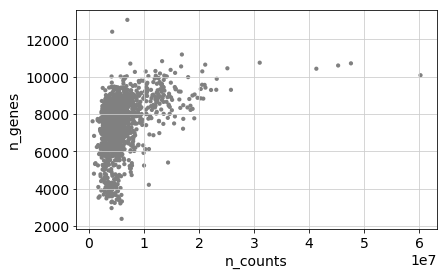

In [4]:
sc.pl.scatter(adata, x="n_counts", y='n_genes')

In [5]:
adata = adata[adata.obs['n_genes'] < 10000, :]
adata = adata[adata.obs['n_counts'] < 10000000, :]
adata.raw = sc.pp.log1p(adata, copy=True)
adata

AnnData object with n_obs × n_vars = 1523 × 18662 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

In [6]:
# Normalize
sc.pp.normalize_per_cell(adata)

In [ ]:
# Save the complete matrix
df = pd.DataFrame(adata.X)
df.columns = adata.var.index
df.to_csv(out_path + "tasic_norm_counts_all.txt", sep="\t")

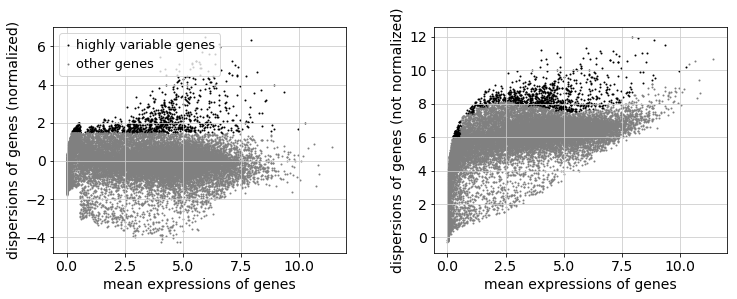

In [7]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, n_top_genes=1000)
#filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [8]:
adata = adata[:, filter_result.gene_subset]
sc.pp.normalize_per_cell(adata)
adata.X_noscale = adata.X
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata)

regressing out ['n_counts']
    finished (0:00:44.50)


In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/kevin/anaconda3/envs/cdn/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:123: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


    finished (0:00:18.70) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:21.74) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [ ]:
sc.tl.louvain(adata, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)


In [ ]:
sc.pl.umap(adata, color='louvain',  legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['C1qc', 'Flt1', 'Mag', 'Lcat', 'Pnoc', 'Syt1', 'Mustn1', 'Pdgfra'])

In [ ]:
sc.pl.umap(adata, color=['Snap25', 'Gad1', 'Slc17a7', 'Aqp4', 'Pdgfra', 'Mog', 'Itgam', 'Flt1', 'Dcn'])

In [ ]:
new_celltypes = ['Neurons', 'Neurons2', 'Neurons3', 'Neurons4', 'Neurons5', 'Neurons6', 
                 'Neurons7', 'Neurons8', 'Neurons9', 'Neurons10', 'Neurons11',
                 'Neurons12', 'Neurons13', 'Astrocytes', 'OPC', 'Neurons14', 'Neurons15',
                'Oligodendrocytes','Microglia','Endothelial']
adata.rename_categories('louvain', new_celltypes)
sc.pl.umap(adata, color='louvain', legend_loc='on data')

In [ ]:
# Make new category
celltypes = pd.DataFrame(adata.obs['louvain'])
celltypes.louvain.replace(['Neurons2', 'Neurons3', 'Neurons4', 'Neurons5', 'Neurons6', 'Neurons7', 'Neurons8',
                           'Neurons9', 'Neurons10', 'Neurons11', 'Neurons12', 'Neurons13', 'Neurons14', 'Neurons15'],
                         ['Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons',
                           'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons'], inplace=True)
adata.obs['celltype'] = celltypes.louvain

In [ ]:
sc.pl.umap(adata, color='celltype')

In [ ]:
# Identify hand full of VLMCs manually
df = pd.DataFrame(adata.X)
df.columns = adata.var.index
vlmc = df['Lum']
vlmc_adapted = list(adata.obs['celltype'])
for i in range(len(vlmc)):
    if vlmc[i] > 10:
        vlmc_adapted[i] = "VLMC"
adata.obs['celltype'] = vlmc_adapted

In [ ]:
sc.pl.umap(adata, color='celltype')

In [ ]:
# Save celltypes
celltypes = pd.DataFrame(adata.obs['celltype'])
celltypes.columns = ['Celltype']
celltypes.to_csv(out_path + "tasic_celltypes.txt", sep="\t")

In [ ]:
# Rank the genes
sc.tl.rank_genes_groups(adata, 'celltype')
top_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top_genes.head(num_top_genes)

In [ ]:
top_genes = top_genes.head(num_top_genes)
top_genes_flat = pd.DataFrame(top_genes.values.flatten())
top_genes_flat.to_csv(out_path + "tasic_top_genes_" + str(num_top_genes) +".txt", sep="\t")

# Save the data